# Notebook 025: KNN Models using final predictor set

This notebook contains a KNN crime-type classifier model using an initial set of property-related predictors.

The response variable is:

       'crime-type'

Features used in this initial baseline model include:

       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'

The baseline models tested are Multi-class KNN Models with and without regularization.

In [2]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/model-logistic'
WRITEDIR_ROOT = '../models/logistic'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')

readfile_model_X = os.path.join(READDIR_ROOT, 'X_train.csv')
readfile_model_X_scaled = os.path.join(READDIR_ROOT, 'X_train_scaled.csv')
readfile_model_y = os.path.join(READDIR_ROOT, 'y_train.csv')
readfile_model_X_test = os.path.join(READDIR_ROOT, 'X_test.csv')
readfile_model_X_test_scaled = os.path.join(READDIR_ROOT, 'X_test_scaled.csv')
readfile_model_y_test = os.path.join(READDIR_ROOT, 'y_test.csv')
readfile_model_X_scaler = os.path.join(READDIR_ROOT, 'X_scaler.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}\n'.format(
        readfile_model_X, readfile_tractshapes, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed\X_train.csv
	../data/raw\shapefile/census-tracts/Census_2010_Tracts.shp
	../figures/model-logistic
	../models/logistic



In [4]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

## Read labeled training and TEST data and subset predictors and response variable

In [46]:
# read in labeled model data
X_train_labels = pd.read_csv(readfile_model_X)
X_train_scaled_labels = pd.read_csv(readfile_model_X_scaled)
y_train_labels = pd.read_csv(readfile_model_y)

X_test_labels = pd.read_csv(readfile_model_X_test)
X_test_scaled_labels = pd.read_csv(readfile_model_X_test_scaled)
y_test_labels = pd.read_csv(readfile_model_y_test)

# read in scaled data scaling parameters to restore scaled values if needed
X_scaler = pd.read_csv(readfile_model_X_scaler)

In [47]:
# subset X and Y data to include only the columns used for model training
predictor_columns = list(X_train_labels.iloc[:,17:].columns)
response_column = ['crime-type']

X_train = X_train_labels[predictor_columns].copy()
X_train_scaled = X_train_scaled_labels[predictor_columns].copy()
y_train = y_train_labels[response_column].values.ravel()

X_test = X_test_labels[predictor_columns].copy()
X_test_scaled = X_test_scaled_labels[predictor_columns].copy()
y_test = y_test_labels[response_column].values.ravel()

In [48]:
def reclass_subset_data(class_map_dict, X_train, X_test, y_train, y_test):
    """
    Subsets multi-class training and test datasets based on a class map
    dictionary.
   
    All observations associated class values not included in the class map
    dictionary will be dropped from the datasets.
   
    class_map_dict: dict, provides the class mapping values, each key
                    represents the original class value, and each value
                    indicates the new class value to which the key
                    should be mapped
   
    X_train, X_test: pd.DataFrames, the X train and test sets to subset
    y_train, y_test: np.array, the y train and test sets to be subsetted
                     and for which the values should be mapped as specified
                     in the class_map_dict
   
    returns: 4 objects, the subsetted and remapped X_train, X_test, y_train,
             and y_test datasets
    """
    # identify indices to required to subset both or the train and test datasets
    subset_index_train = np.isin(y_train, list(class_map_dict.keys()))
    subset_index_test = np.isin(y_test, list(class_map_dict.keys()))
   
    # subset the X training and test datasets
    X_train_subset = X_train.copy()[subset_index_train]
    X_test_subset = X_test.copy()[subset_index_test]

    # subset the y training and test arrays
    y_train_subset = y_train.copy()[subset_index_train]
    y_test_subset = y_test.copy()[subset_index_test]

    # remap classes in the y arrays as per the class_map_dict
    y_train_new = np.vectorize(class_map_dict.get)(y_train_subset)
    y_test_new = np.vectorize(class_map_dict.get)(y_test_subset)
   
    return X_train_subset, X_test_subset, y_train_new, y_test_new

In [49]:
# For input into the reclass_subset_data() function
subset_class_map_dict = {
    2: 0,
    6: 1,
    8: 2,
    5: 2,
}

# For use later for labeling classes in plots, etc.
subset_class_dict = {
    0: 'drugs-substances',
    1: 'theft',
    2: 'violence-aggression'
}

# subset and reclass datasets for models
X_train_scaled, X_test_scaled, y_train, y_test = reclass_subset_data(
    subset_class_map_dict, X_train_scaled, X_test_scaled, y_train, y_test
)

In [50]:
# summarize dataframe info
print('Y TRAIN DATA WITH ADDITIONAL LABELS\n')
y_train_labels.info()
print('\n\nX TRAIN DATA WITH ADDITIONAL LABELS\n')
X_train_labels.info()
print('\n\nX TRAIN PREDICTORS (WITH LABEL COLUMNS EXCLUDED)\n')
print(predictor_columns)
print('\n\nTHE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY\n')
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\n\nX SCALER DATA INFO\n')
X_scaler.info()
print(
    '\n\nTHE X SCALER DATA CONTAINS MEANS AND STDS FOR THE FOLLOWING STANDARDIZED '\
    '(i.e. SCALED) PREDICTORS\n\n{}'.format(X_scaler['scaled-feature'].values)
)

Y TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 4 columns):
crime-type             128352 non-null int64
crime-type-cat         128352 non-null object
OFFENSE_DESCRIPTION    128352 non-null object
INCIDENT_NUMBER        128352 non-null object
dtypes: int64(1), object(3)
memory usage: 3.9+ MB


X TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 60 columns):
date                                 128352 non-null object
year                                 128352 non-null int64
month                                128352 non-null int64
hour                                 128352 non-null int64
time                                 128352 non-null int64
ZIP5                                 128352 non-null int64
ZIP5_area                            128352 non-null float64
Name                                 128352 non-null o

In [51]:
# create lists of predictors based on numeric type for easier treatment of specific types
predictors_binary = [
    'night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
    'college-near', 'highschool-near'
]
predictors_nonbinary = [col for col in X_train.columns if col not in predictors_binary]
predictors_discrete = [
    'streetlights-night',
    'median-age',
]
predictors_continuous = [col for col in predictors_nonbinary if col not in predictors_discrete]

print(
    'Binary predictors in the X training data are:\n\n{}\n\n\n'\
    'Non-binary predictors are:\n\n{}\n\n\n'\
    'Of the non-binary, the following are discrete:\n\n{}\n\n\n'\
    'And these remaining are continuous:\n\n{}\n'.format(
        predictors_binary,
        predictors_nonbinary,
        predictors_discrete,
        predictors_continuous
    )
)

Binary predictors in the X training data are:

['night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'college-near', 'highschool-near']


Non-binary predictors are:

['streetlights-night', 'lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-age', 'median-income', 'poverty-rate', 'less-than-high-school-perc', 'bachelor-degree-or-more-perc', 'enrolled-college-perc', 'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-median-value', 'residential-gini-coef', 'commercial-mix-ratio-3yr-cagr', 'industrial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-gini-coef-3yr-cagr', 'residential-median-value-3yr-cagr']


Of the non-binary, the following are discrete:

['streetlights-night', 'median-age']


And these remaining are continuous:

['lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-income', 'poverty-rate', 'less

## Create value count summary tables by crime-type for later reference

In [52]:
agg_dict = {'INCIDENT_NUMBER': 'count'}

crime_types_train = y_train_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_train['proportion'] = crime_types_train / crime_types_train.sum()

crime_types_test = y_test_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_test['proportion'] = crime_types_test / crime_types_test.sum()

class_dict = dict(
    zip(crime_types_test.reset_index()['crime-type'], crime_types_test.reset_index()['crime-type-cat'])
)

In [53]:
print(
    'The number of observed crime type classes in both the training and test set are:\n\n'\
    'TRAINING\n{}\n\n\nTEST\n{}\n'.format(
        crime_types_train,
        crime_types_test
    )
)

The number of observed crime type classes in both the training and test set are:

TRAINING
                                   count  proportion
crime-type crime-type-cat                           
0          other                    6321    0.049247
1          burglary                 5664    0.044129
2          drugs-substances        13082    0.101923
3          fraud                    9587    0.074693
4          harassment-disturbance  20767    0.161797
5          robbery                  3423    0.026669
6          theft                   34555    0.269221
7          vandalism-property      13710    0.106816
8          violence-aggression     21243    0.165506


TEST
                                   count  proportion
crime-type crime-type-cat                           
0          other                    1580    0.049240
1          burglary                 1416    0.044129
2          drugs-substances         3271    0.101938
3          fraud                    2397    0.074701
4

## Use KNN Model on Subset of Data

In [54]:
KNNModels = {}  # dictionary for KNN models

k_values = [3,9,15,23,35,53,75,97,135,205,405,605]  # values of k we want to run models for

# run KNN for each value of k in k_values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', p=1, n_jobs=-1)  #p=1 manhattan distance is 0.02 better
    knn.fit(X_train_scaled, y_train)
    KNNModels[k] = knn

KNNModels

{3: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
                      weights='distance'),
 9: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=9, p=1,
                      weights='distance'),
 15: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=15, p=1,
                      weights='distance'),
 23: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=23, p=1,
                      weights='distance'),
 35: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=35, p=1,
                      weights='distance'),
 53: KNeighborsClassifier(alg

In [55]:
%%time

accuracy_test_scores = [] # Accuracy scores

for k, model in KNNModels.items():  # use the pre-trained models stored in the KNNModels dictionary
    accuracy = model.score(X_test_scaled, y_test) 
    accuracy_test_scores.append(accuracy)

display(accuracy_test_scores)

[0.5484620491259128,
 0.5708121265766762,
 0.5797189643726488,
 0.5846426200486834,
 0.5893449878291658,
 0.5949878291657447,
 0.5992476211551229,
 0.5980858597034742,
 0.6029541934056207,
 0.6008519583978756,
 0.6023456516928524,
 0.6010179243195397]

Wall time: 7min


In [56]:
# combine multiple lists into dataframe (https://stackoverflow.com/questions/30522724)
df_accuracy = pd.DataFrame({'KNN':k_values, 'Test_Accuracy':accuracy_test_scores})

display(df_accuracy)

,KNN,Test_Accuracy
0,3,0.548462
1,9,0.570812
2,15,0.579719
3,23,0.584643
4,35,0.589345
5,53,0.594988
6,75,0.599248
7,97,0.598086
8,135,0.602954
9,205,0.600852


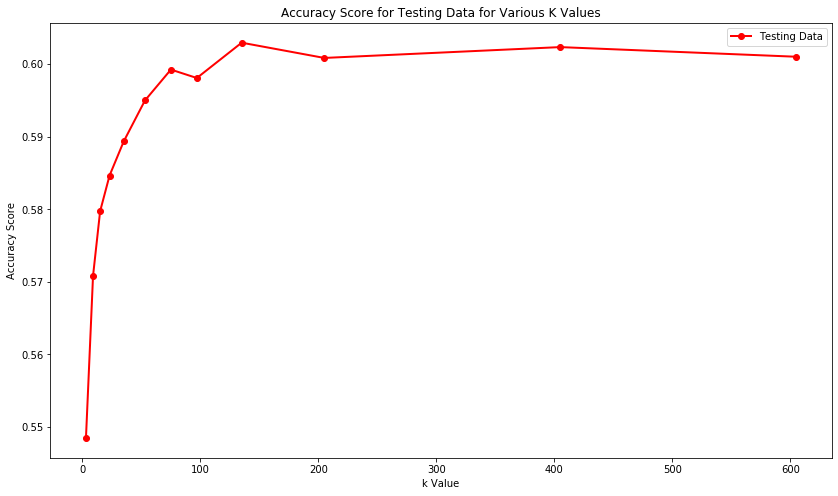

In [57]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.plot(df_accuracy['KNN'], df_accuracy['Test_Accuracy'], label='Testing Data', linewidth=2, marker='o', color='red')

ax.set_xlabel('k Value')
ax.set_ylabel('Accuracy Score')
ax.set_title('Accuracy Score for Testing Data for Various K Values')

ax.legend()
plt.show()

**The curve flattens out as k increases with an asymptote around 0.355.  The elbow of the curve is around a k value of 100.  And the curve really flattens out beyond a k value of around 200.**

**To maximize predictability we will use a k value of 205 below.**

## Results Analysis for Selected Model

In [58]:
knn = KNeighborsClassifier(n_neighbors=135, weights='distance', p=1, n_jobs=-1)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=135, p=1,
                     weights='distance')

In [59]:
%%time

knn_train_pred  = knn.predict(X_train_scaled)
knn_test_pred = knn.predict(X_test_scaled)

Wall time: 3min 47s


In [60]:
%%time

knn_train_pred_prob  = knn.predict_proba(X_train_scaled)
knn_test_pred_prob = knn.predict_proba(X_test_scaled)

Wall time: 3min 33s


In [61]:
knn_train_accuracy = accuracy_score(y_train, knn_train_pred)
knn_test_accuracy = accuracy_score(y_test, knn_test_pred)

print('Training Accuracy:\n', knn_train_accuracy)
print('\n')
print('Testing Accuracy:\n', knn_test_accuracy)

Training Accuracy:
 0.9821860780327234


Testing Accuracy:
 0.6029541934056207


In [62]:
def summarize_predictions(predictions_train, predictions_test):
    """
    Generates a summary table of the training and test predictions, showing count
    and proportion by class
    
    predictions_train: np.array, the predicted classes generated on the training data
    predictions_test:np.array, the predicted classes generated on the test data
    
    returns: tuple of 2 pd.DataFrame objects, one summarizing the training predictions
             the other summarizing the test predictions
    """
    frame_name_list = ['pred_counts_train', 'pred_counts_test']
    
    for predictions, name in zip(
        [predictions_train, predictions_test],
        frame_name_list
    ):
        locals()[name] = np.array(np.unique(predictions, return_counts=True)).T
        locals()[name] = np.hstack(
            [locals()[name], locals()[name][:,1].reshape(-1,1)/np.sum(locals()[name][:,1])]
        )
        locals()[name] = pd.DataFrame(locals()[name], columns=['class', 'count', 'proportion'])
        locals()[name][['class', 'count']] = locals()[name][['class', 'count']].astype(int)
        locals()[name] = locals()[name].set_index('class')

    return locals()[frame_name_list[0]], locals()[frame_name_list[1]]

In [63]:
knn_train_pred_summary, knn_test_pred_summary = summarize_predictions(knn_train_pred, knn_test_pred)

print('Training Predictions:\n', knn_train_pred_summary)
print('\n\n')
print('Testing Predictions:\n', knn_test_pred_summary)

Training Predictions:
        count  proportion
class                   
0      13433    0.185788
1      35111    0.485609
2      23759    0.328603



Testing Predictions:
        count  proportion
class                   
0       2936    0.162425
1       9817    0.543096
2       5323    0.294479


In [64]:
def make_conf_matrix(predictions, y_actual):
    """
    Generates a confusion matrix of actual classes versus predicted classes
    
    predictions: np.array, predicted class values generated by the model
    y_actual: np.array, actual class values
    
    returns: pd.DataFrame, the resulting confusion matrix with marginal totals included
    """
    class_labels = sorted(list(set(y_actual)))
    
    conf_matrix = pd.DataFrame(confusion_matrix(predictions, y_actual), columns=class_labels)
    conf_matrix.index.name = 'Predicted'
    conf_matrix.columns.name = 'Actual'
    conf_matrix.loc['Total'] = conf_matrix.sum(axis=0)
    conf_matrix['Total'] = conf_matrix.sum(axis=1)
    
    return conf_matrix

In [65]:
print('Confusion Matrix for KNN with k = 205 (Testing):\n')
knn_conf_matrix = make_conf_matrix(y_test, knn_test_pred)

knn_conf_matrix

Confusion Matrix for KNN with k = 205 (Testing):



Actual,0,1,2,Total
Predicted,,,,
0,1857,851,563,3271
1,559,6181,1899,8639
2,520,2785,2861,6166
Total,2936,9817,5323,18076


In [66]:
def generate_class_metrics(conf_matrix):
    """
    Generates a dataframe of the various by-class classification metrics that
    can be calculated directly from a confusion matrix, such as True Positive Rate,
    False Negative Rate, etc.
    
    conf_matrix: pd.DataFrame, generated with the make_conf_matrix function
    
    returns: pd.DataFrame, each row representing a different class, each
             column a different classification metric for each class
    """
    # rename index
    conf_matrix = conf_matrix.copy()
    conf_matrix.index.name = 'class'
    conf_matrix.columns.name = 'class'
    results = dict()
    
    # True Pos, False Pos, False Neg, True Neg counts
    results['TP'] = pd.Series(np.diag(conf_matrix.iloc[:-1,:-1]))
    results['TP'].index.name = 'class'
    results['FP'] = conf_matrix.iloc[:-1,:-1].sum(axis=1) - results['TP']  
    results['FN'] = conf_matrix.iloc[:-1,:-1].sum(axis=0) - results['TP']
    results['TN'] = conf_matrix.iloc[:-1,:-1].values.sum() -\
                    (results['FP'] + results['FN'] + results['TP'])

    # true positive rate
    results['TPR'] = results['TP']/(results['TP']+results['FN'])
    # false negative rate
    results['FNR'] = results['FN']/(results['TP']+results['FN'])
    # false positive rate
    results['FPR'] = results['FP']/(results['FP']+results['TN'])
    # true negative rate
    results['TNR'] = results['TN']/(results['TN']+results['FP']) 
    # positive predictive value
    results['PPV'] = results['TP']/(results['TP']+results['FP'])
    # negative predictive value
    results['NPV'] = results['TN']/(results['TN']+results['FN'])
    
    # convert results dictionary to a dataframe 
    results_df = pd.concat(
        [
            # first separate the integer values so they format correctly
            pd.DataFrame(
                list(results.values())[:4],
                index=list(results.keys())[:4]
            ).T,
            # followed by the float values
            pd.DataFrame(
                list(results.values())[4:],
                index=list(results.keys())[4:]
            ).T
        ], axis=1
    )
    
    return results_df

In [67]:
generate_class_metrics(knn_conf_matrix)

,TP,FP,FN,TN,TPR,FNR,FPR,TNR,PPV,NPV
class,,,,,,,,,,
0,1857,1414,1079,13726,0.632493,0.367507,0.093395,0.906605,0.567716,0.927119
1,6181,2458,3636,5801,0.629622,0.370378,0.297615,0.702385,0.715476,0.614708
2,2861,3305,2462,9448,0.537479,0.462521,0.259155,0.740845,0.463996,0.793283


## Calculate and Plot AUC

In [68]:
##################################################################
# DEFINE FUNCTIONS FOR CALCULATING ROC AND AUC AND PLOTTING CURVES
##################################################################

# MULTI-CLASS AUC REQUIRES scikit-learn v0.22

def generate_roc_auc(y_values_actual, predicted_probabilities, class_dict):
    """
    Creates a dictionary of ROC curve values generated using
    sklearn.metrics.roc_curve for every outcome class in a multi-class
    problem
    
    NOTE: multi-class AUC requires scikit-learn>=v0.22
    y_values_actual: np.array, the 1-dimensional array containing the 
                     multi-classs true y values against which you are evaluating
                     the predicted probabilities (i.e. y_test)
    predicted_probabilities: np.array, the 2-dimensional array generated
                             using sklearn's "model.predict_proba()" method
                             (i.e. test set predicted probabilities)
                     
    returns: tuple(float, float, dict), (1) a float representing the average macro AUC
             for all classes, (2) a float representing the average weighted AUC (weighted
             by the number of true samples for each class to account for class imbalance)
             and (3) a dictionary of dictionaries, where each top level key represents a
             different y class, and the value for each y class key is a dictionary
             containing the corresponding frp, tpr, threshold, and individual class AUC
             values for that particular y class outcome. Example output format shown below:
             
             (
                 auc_average,
                 auc_weighted_average,
                 output_dict = {
                    0: {
                        'frp': np.array of shape (n,)
                        'tpr': np.array of shape (n,)
                        'threshold': np.array of shape (n,)
                        'auc': float of micro auc for individual class
                        'name': str name of class
                    }
                    1: {
                        'frp': ...
                        ...
                    }
                    ...
                 }
            )
    """
    # create sorted list of all class labels
    class_labels = sorted(list(set(y_values_actual)))

    # convert y_values to binary indicators for each class and store as 2D
    # array of dimensions (n_classes, n_y_values), with each row containing one
    # set of class indicators
    y_class_array = np.vstack(
        [
            (y_values_actual==class_val).astype(int) for class_val in class_labels
        ]
    )

    # create roc curve dictionary
    roc_curve_dict = {
        crime_class: {
            key: value
            for key, value in zip(
                ['fpr', 'tpr', 'thresholds'],
                roc_curve(y_class, predicted_probs_class)
            )
        } for (crime_class, predicted_probs_class), y_class in zip(
            enumerate(predicted_probabilities.T),
            y_class_array
        )
    }
    
    # add individual class auc's and class names to dictionary
    for crime_class in class_labels:
        roc_curve_dict[crime_class]['auc'] = roc_auc_score(
            y_class_array[crime_class],
            predicted_probabilities[:,crime_class]
        )
        roc_curve_dict[crime_class]['name'] = class_dict[crime_class]
    
    # generate overall average auc's for all classes, weighted and unweighted
    auc_avg = roc_auc_score(
        y_values_actual, predicted_probabilities, multi_class='ovr', average='macro'
    )
    auc_weighted_avg = roc_auc_score(
        y_values_actual, predicted_probabilities, multi_class='ovr', average='weighted'
    )
    
    return auc_avg, auc_weighted_avg, roc_curve_dict


In [75]:
knn_auc_avg, knn_weighted_auc_avg, knn_roc_curve = generate_roc_auc(y_test, knn_test_pred_prob, subset_class_dict)

print('KNN AUC Average:\n', knn_auc_avg)
print('\n')
print('KNN Weighted AUC Average:\n', knn_weighted_auc_avg)

KNN AUC Average:
 0.7564491681029443


KNN Weighted AUC Average:
 0.7411505322842994


In [77]:
def plot_roc_all_classes(overall_auc, overall_auc_weighted, roc_curve_dict,
                         title='ROC plotted for all crime type TEST classes',
                         savepath=None):
    """
    Generates a plot of ROC curves for all responses classes
    overall_auc: float, an overall average auc generated using the
                 'generate_roc_auc' function
    overall_auc_weighted: float, an overall weighted auc generated using the
                          'generate_roc_auc' function
    roc_curve_dict: dict, an roc_curve dict generated using the 'generate_roc_auc'
                    function
    title: str, specifies the title used for the plot
    savepath: None or str, if none, .png file is NOT saved, otherwise, input the
              "filepath.png" string, indicating where you would like the image saved
    returns: A plotted image and saved .png file (if savepath is not None)
    """
    fig, ax = plt.subplots(figsize=(12, 7))

    plt.title(
        ''.join(
            [title, '\n(overall AUC, avg.: {:.3f}; weighted avg.: {:.3})'.format(
                overall_auc,
                overall_auc_weighted
            )
            ]
        ),
        fontsize=20,
    )

    rate_values=np.arange(0,100)/100

    ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=1)

    for key in roc_curve_dict.keys():
        plt.plot(
            roc_curve_dict[key]['fpr'],
            roc_curve_dict[key]['tpr'],
            label='{} : {:.3f}'.format(
                key,
                roc_curve_dict[key]['auc']
            )
        )
        plt.legend(
            fontsize=14,
            title='class : AUC',
            title_fontsize=14,
            edgecolor='k',
            framealpha=1,
            loc=4
        )

    ax.tick_params(labelsize=16)
    ax.set_ylabel("TRUE positive rate", fontsize=18)
    ax.set_xlabel("FALSE positive rate", fontsize=18)
    ax.grid(':', alpha=0.4)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show();

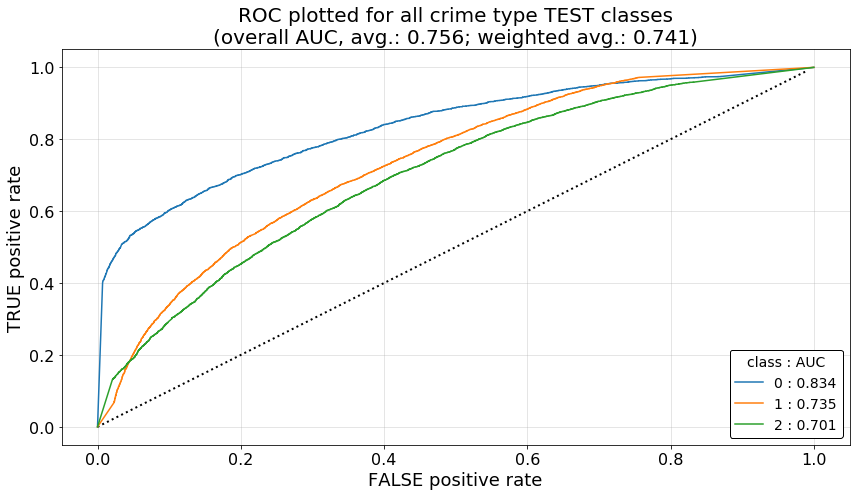

In [78]:
plot_roc_all_classes(knn_auc_avg, knn_weighted_auc_avg, knn_roc_curve)

In [79]:
def plot_roc_all_classes_individual(overall_auc, overall_auc_weighted, roc_curve_dict,
                                    title='ROC plotted by crime type TEST class',
                                    savepath=None, subplots=(5,2), fig_height=15,
                                    suptitle_spacing=0.91):
    """
    Generates a set of subplot of ROC curves for all responses classes, each plotted
    individually
    
    overall_auc: float, an overall average auc generated using the
                 'generate_roc_auc' function
    overall_auc_weighted: float, an overall weighted auc generated using the
                          'generate_roc_auc' function
    roc_curve_dict: dict, an roc_curve dict generated using the 'generate_roc_auc' 
                    function
    title: str, specifies the title used for the plot
    savepath: None or str, if none, .png file is NOT saved, otherwise, input the 
              "filepath.png" string, indicating where you would like the image saved
    subplots: tuple, default=(5,2) to plot each of the 9 crime classes,
              provides the dimension of subplots for the figure (NOTE: currently this
              function is only configured to plot 2 columns of subplots, therefore
              no other value other than two is accepted for the subplots width dimension)
    fig_height: int or float, default=15, this value is passed directly to the 'figsize'
                parameter of plt.subplots() and determines the overall height of your plot
    suptitle_spacing: float between 0 and 1, default=0.91,
                      this value is passed to the 'rect' parameter for plt.tight_layout()
                      to specify the proportion of the overall plot space to reserve for
                      the plt.suptitle() text. If you change the fig_height parameter from
                      the default, you may find that you need to adjust suptitle_spacing
                      to adjust the position of your suptitle. The larger your fig_height
                      value, the larger suptitle_spacing you will need and vice versa.
    
    returns: A plotted image and saved .png file (if savepath is not None)
    """
    if type(subplots)!=tuple:
        raise TypeError("'subplots' parameter must be entered as a tuple, e.g. subplots=(3,2)")
    if subplots[1]!=2:
        raise ValueError(
            "'subplots' parameter columns dimension must be value=2, e.g. subplots=(5,2). "\
            "This function is not configured to handle more or less than 2 subplots."
        )
    
    fig, axes = plt.subplots(*subplots, figsize=(12, fig_height))

    plt.suptitle(
        ''.join(
            [title, '\n(overall AUC, avg.: {:.3f}; weighted avg.: {:.3})'.format(
                overall_auc,
                overall_auc_weighted
            )
            ]
        ),
        fontsize=20,
    )

    rate_values=np.arange(0,100)/100
    
    for (i, ax), (j, key) in zip(enumerate(axes.flat), enumerate(roc_curve_dict.keys())):
        ax.set_title('class {}: {}'.format(key, roc_curve_dict[key]['name']), fontsize=16)
        ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=.3)

        ax.plot(
            roc_curve_dict[key]['fpr'],
            roc_curve_dict[key]['tpr'],
            label='{} ({:.4f})'.format(
                key,
                roc_curve_dict[key]['auc']
            ),
            color='k'
        )
        ax.text(0.7, 0.1, 'AUC = {:.3f}'.format(roc_curve_dict[key]['auc']), fontsize=14)
        ax.tick_params(labelsize=14)
        ax.set_ylabel("TRUE positive rate", fontsize=14)
        ax.set_xlabel("FALSE positive rate", fontsize=14)
        ax.grid(':', alpha=0.4)
    
    # hide all markings for axes if there is no corresponding subplot
    if i < np.product(subplots)-1:
        for pos in ['right','top','bottom','left']:
            axes[subplots[0]-1, 1].spines[pos].set_visible(False)
        axes[subplots[0]-1, 1].tick_params(
            axis='x', which='both', bottom=False, top=False, labelbottom=False
        )
        axes[subplots[0]-1, 1].tick_params(
            axis='y', which='both', right=False, left=False, labelleft=False
        )
    
    plt.tight_layout(rect=[0, 0.03, 1, suptitle_spacing])
    if savepath:
        plt.savefig(savepath)
    plt.show();

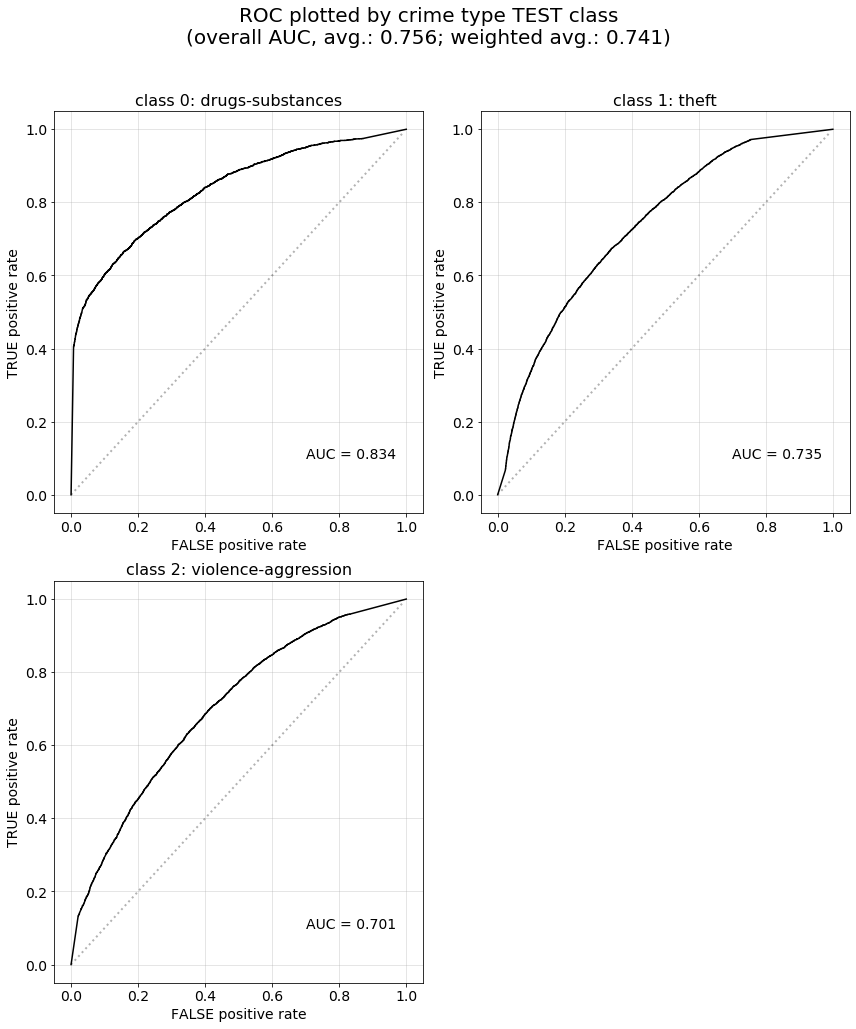

In [81]:
plot_roc_all_classes_individual(knn_auc_avg, knn_weighted_auc_avg, knn_roc_curve, subplots=(2,2))